In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

# Part 0 - Creating an image to work with
We used the `PIL` library to create a $512\times 512$ grayscale image, sampled in a gaussian distribution with $\mu=128, \sigma=70$.

In [15]:
def create_image():
    mu, sigma, eps = 0, 1, 0.05
    data = np.random.normal(loc=mu, scale=sigma, size=512*512) + eps # 1D grayscale array with size 512*512
    data_max = data.max()
    data_min = data.min()
    new_data = np.array([256 * (x - data_min) / (data_max - data_min) for x in data]) # standardize new data to eliminate <0 and >256
    new_data.resize((512, 512)) # Create 2D (512, 512) array from data
    pil_image = Image.fromarray(new_data.astype(np.uint8))

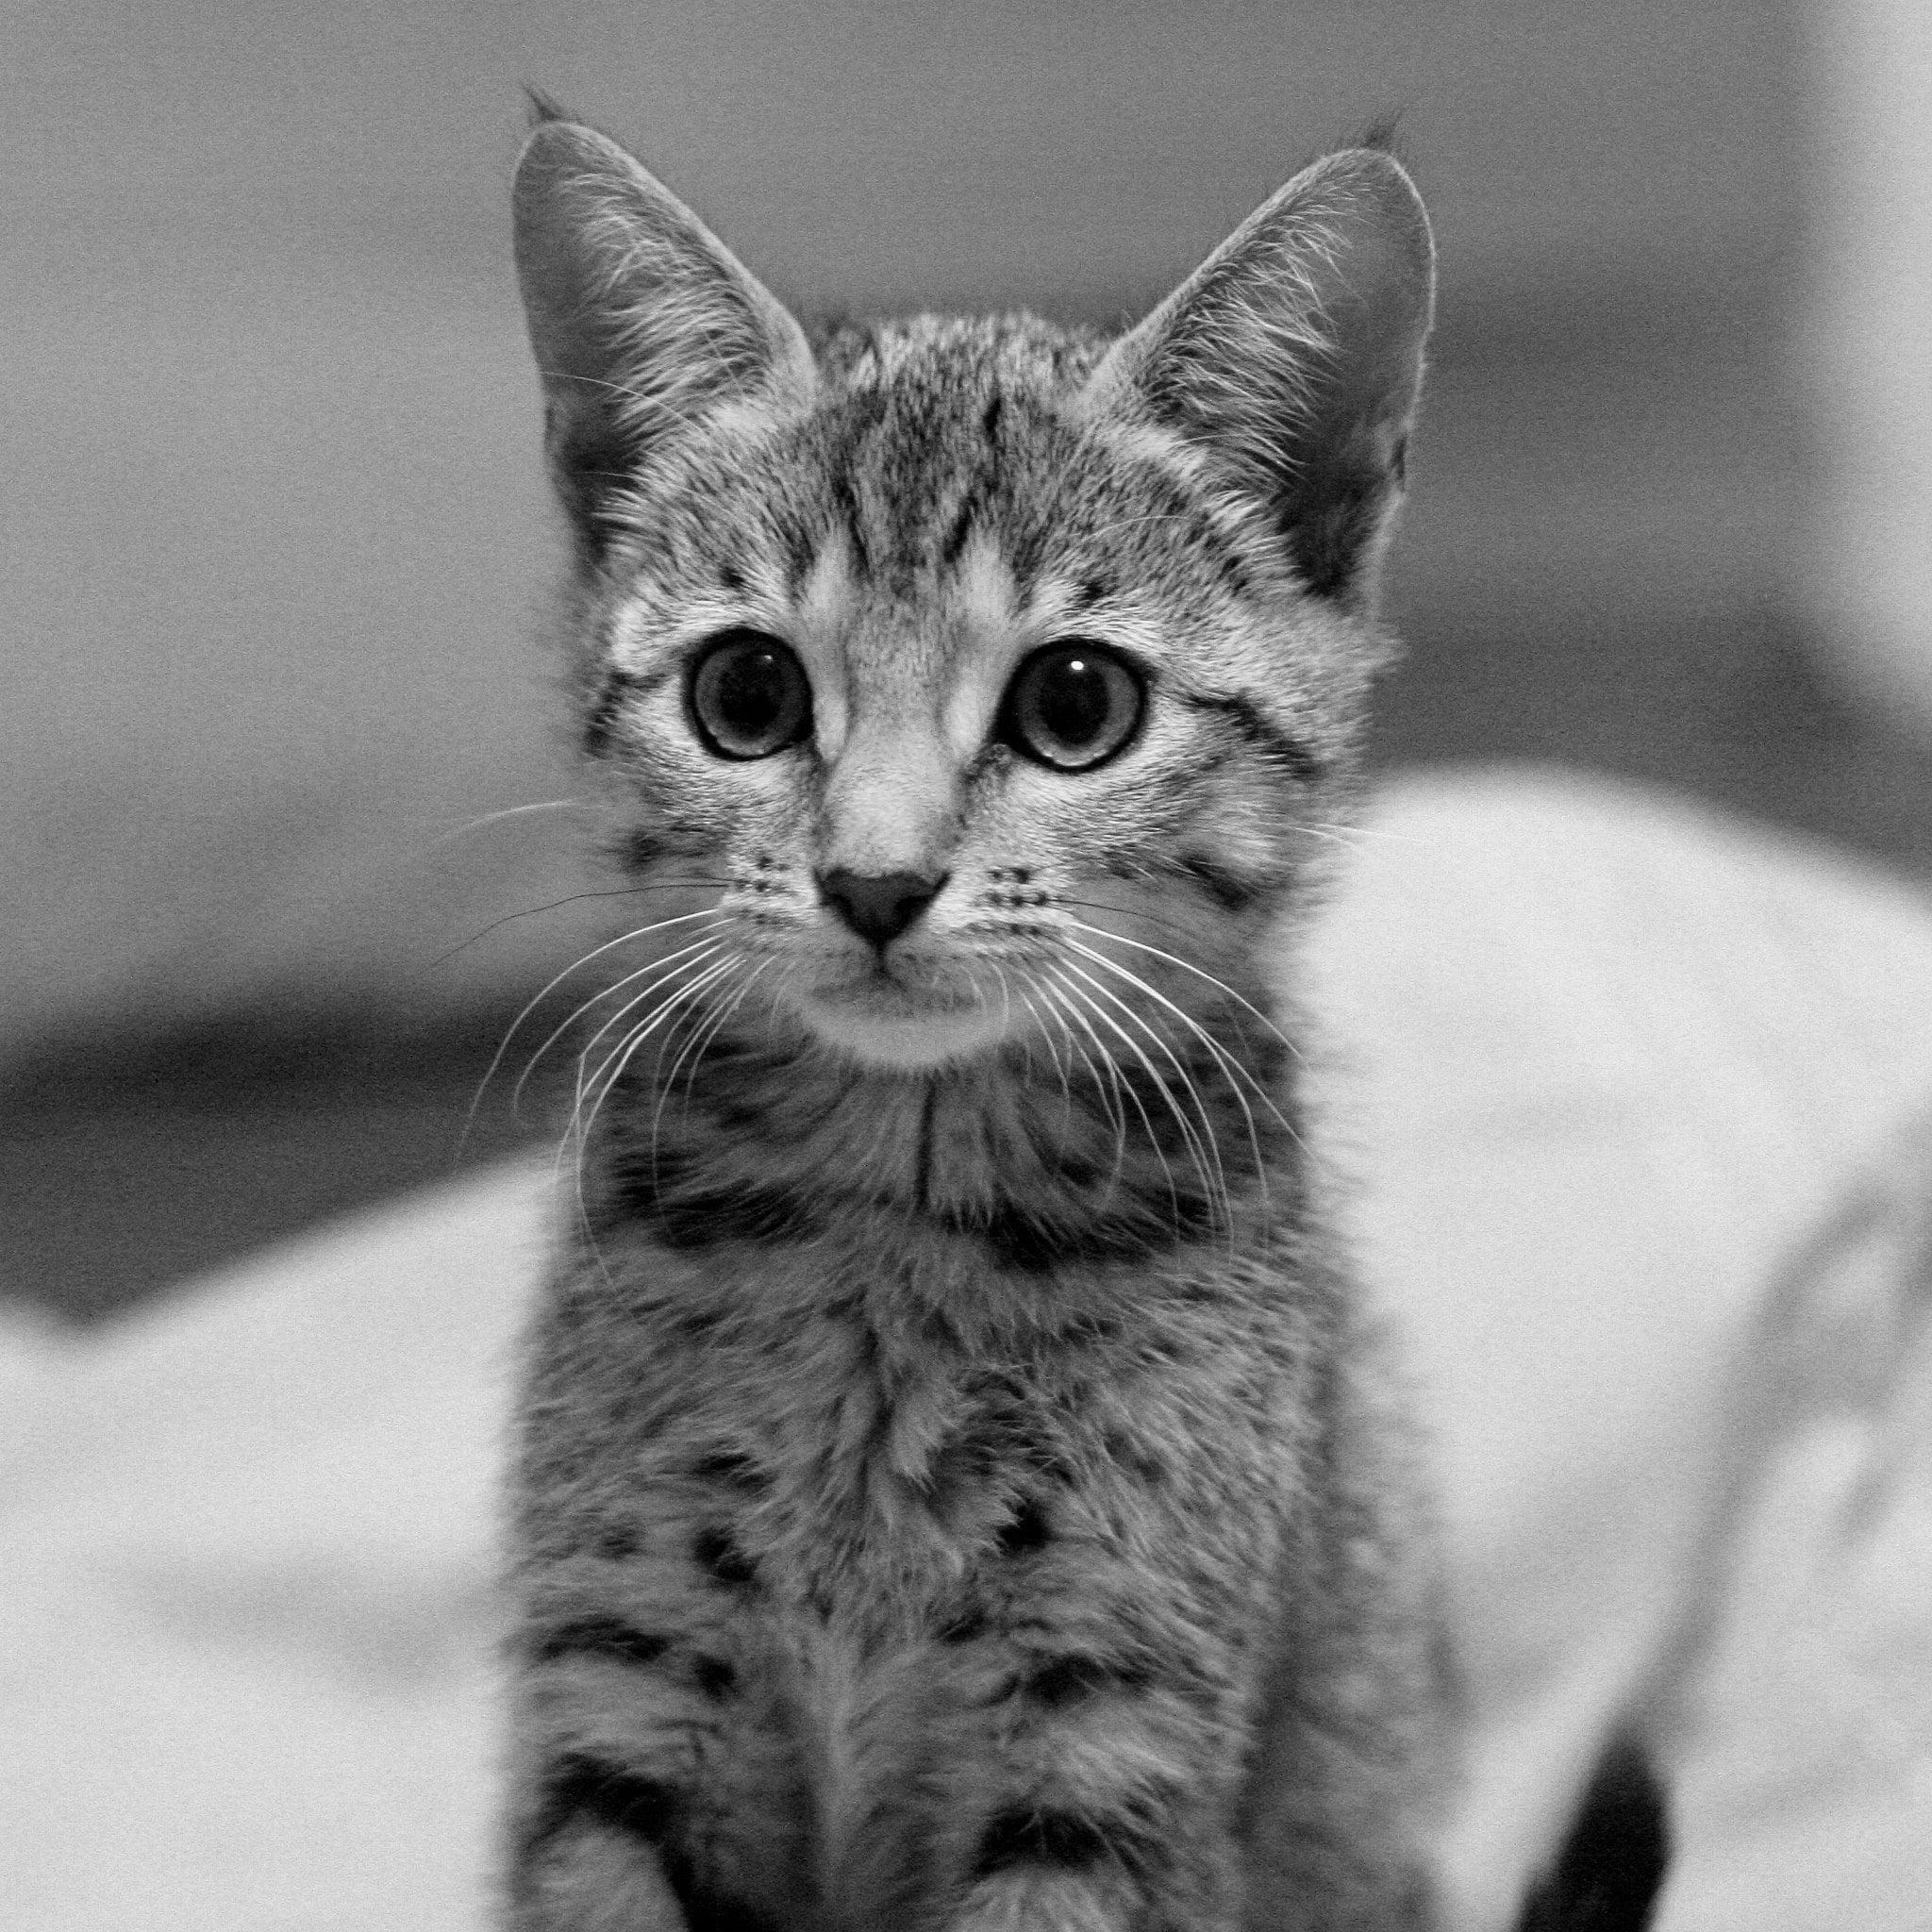

<BarContainer object of 256 artists>

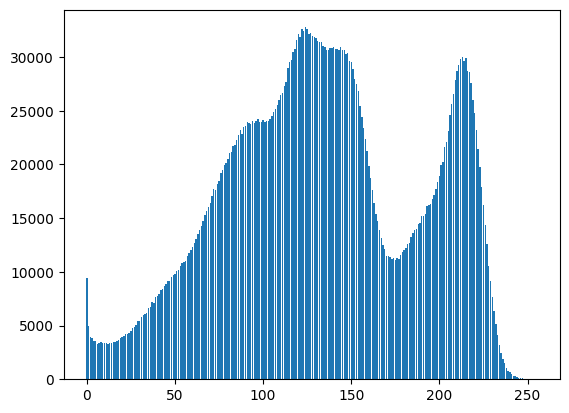

In [16]:
# pil_image = create_image()
pil_image = Image.open('imgs/cat_photo.jpeg').convert('L')
display(pil_image)
plt.bar(range(256), height=pil_image.histogram())

# Part 1 - Quantization
We would apply a uniform quantization on this image using $b$ bits per pixel.

For each $b\in[1,\dots,8]$, we'll show the MSE we got:

In [17]:
def create_uniform_decision_levels(low, high, b):
    decision_levels = []
    k = 2**b
    delta = (high - low) / k
    for i in range(0, k+1): 
        decision_levels.append(low + i * delta)
    return decision_levels

In [18]:
def create_uniform_represantation_levels(low, high, b):
    repr_levels = []
    k = 2**b
    delta = (high - low) / k
    for i in range(1, k+1):
        repr_levels.append(low + (i - 0.5) * delta)
    return repr_levels

The MSE loss as a function of the bit-budget $b\in[1,\dots,8]$:

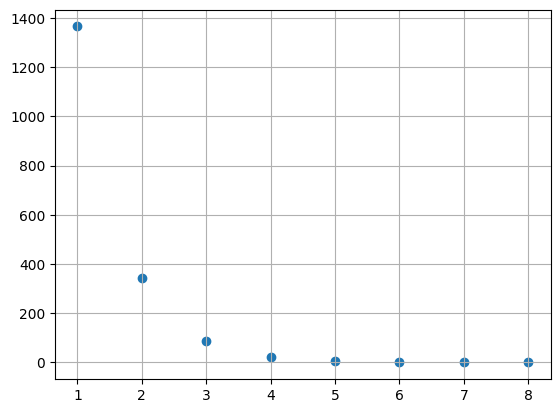

In [19]:
b_list = list(range(1, 9))
delta_list = [256/(2**b) for b in b_list]
uniform_mse_list = [delta**2 / 12 for delta in delta_list]

fig = plt.figure()
ax = fig.gca()
plt.scatter(b_list, uniform_mse_list)
plt.grid()
plt.show()

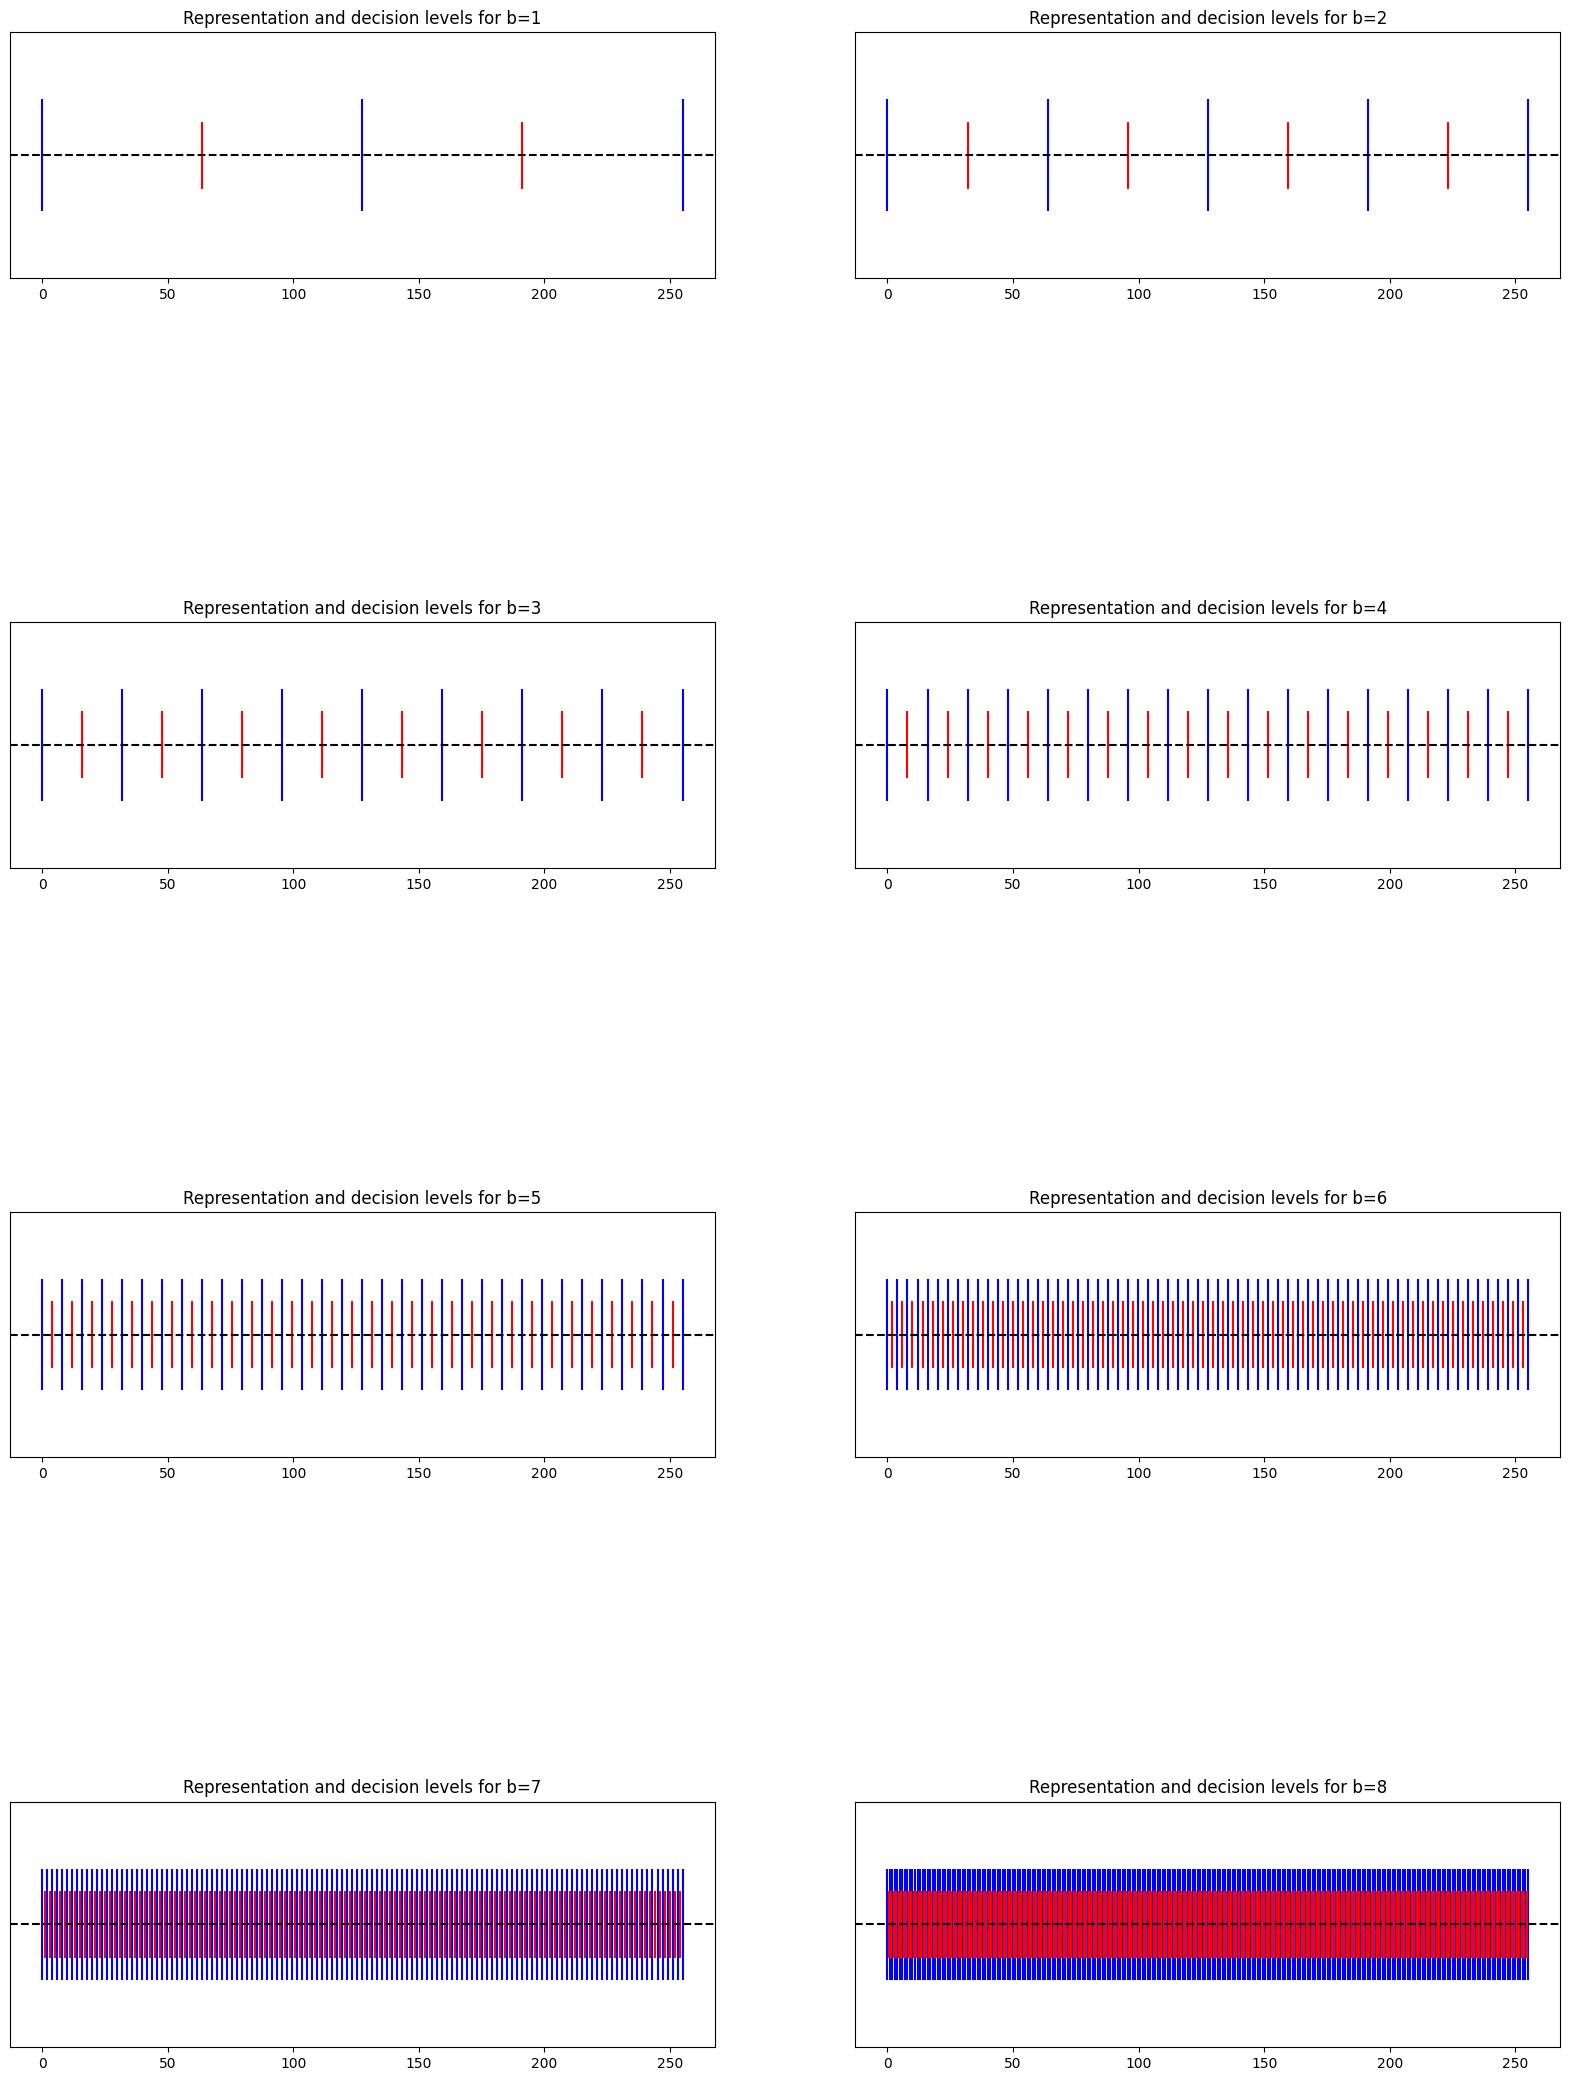

In [20]:
plt.figure( figsize=(20,30) )
for b in range(1, 9, 2):
    plt.subplot(8, 2, 2 * b - 1)
    plt.title(f"Representation and decision levels for b={b}")
    plt.eventplot(create_uniform_decision_levels(0, 255, b), 'horizontal', linelengths=0.5, colors='blue')
    plt.eventplot(create_uniform_represantation_levels(0, 255, b), 'horizontal', linelengths=0.3, colors='red')
    plt.axhline(y=1, color='black', linestyle='--')
    plt.yticks([])
    plt.subplot(8, 2, 2 * b)
    plt.title(f"Representation and decision levels for b={b+1}")
    plt.eventplot(create_uniform_decision_levels(0, 255, b+1), 'horizontal', linelengths=0.5, colors='blue')
    plt.eventplot(create_uniform_represantation_levels(0, 255, b+1), 'horizontal', linelengths=0.3, colors='red')
    plt.axhline(y=1, color='black', linestyle='--')
    plt.yticks([])

## Question 3 - Implementation of Max-Lloyd

Pseudo code of the implementation:

**Inputs:** \
$hist$: histogram pdf \
$d$: initial decision levels \
$\epsilon$: convergence tolerance

**Outputs** \
$d$: Converged decision levels \
$r$: Converged representation levels

**Psuedo code**:
1. Loop while $MSE$ is not less than $\epsilon$: \
   1.1 Update representation levels $r_i=\frac{\int_{d_{i-1}}^{d_i} x\cdot p(x)dx}{\int_{d_{i-1}}^{d_i} p(x)dx}$ \
   1.2 Update decision levels $d_i=\frac{r_i + r_{i+1}}{2}$ 
   

In [21]:
def max_lloyd(hist: np.array, d: np.array, eps):
    '''
    @param hist_pdf: histogram pdf
    @param decision_levels: vector of initial decision levels
    @param eps: small value epsilon>0 for convergence tolerance
    @return the converged decision levels and the converged representation levels
    '''
    padding = 1 / 512**2
    r = [0] * (len(d))
    mse = np.Inf
    hist_size = sum(hist)
    c = 0
    # mse_sum
    while c <= 300:
        prev_mse = mse
        # Given the decision levels d_i, compute & update repr levels r_i 
        for i in range(1, len(r)):
            p_x = max(sum([hist[n] / hist_size for n in range(len(hist)) if d[i-1] <= n <= d[i]]), padding)
            x_p_x = max(sum([n * hist[n] / hist_size for n in range(len(hist)) if d[i-1] <= n <= d[i]]), padding)
            r[i] = x_p_x / p_x
        # Given repr levels r_i, compute and update decision levels d_i
        for i in range(len(d))[1:-1]:
            d[i] = (r[i] + r[i+1]) / 2
        # update MSE
        mse = 0
        for i in range(1, len(r)):
            p_x = max(sum([hist[n] / hist_size for n in range(len(hist)) if d[i-1] <= n <= d[i]]), padding)
            x_p_x = max(sum([(n - r[i])**2 * hist[n] / hist_size for n in range(len(hist)) if d[i-1] <= n <= d[i]]), padding)
            mse += x_p_x
        c += 1
        if prev_mse - mse <= eps:
            break
    return d, r[1:], prev_mse

In [22]:
d = create_uniform_decision_levels(low=0, high=255, b=7)
hist = pil_image.histogram()
max_lloyd(hist, d, 0.1)

([0.0,
  1.4175921112755072,
  3.4927928216535147,
  5.501672949833743,
  7.502139338916235,
  9.500985933488277,
  11.5052762122995,
  13.507005728400252,
  15.50805165230128,
  17.509330504343296,
  19.51019185696208,
  21.505080956811938,
  23.507729473967505,
  25.508222252100204,
  27.51040704122511,
  29.517688425182808,
  31.510301334795717,
  33.51036448200968,
  35.517311903265096,
  37.51698280690367,
  39.512157560873874,
  41.50529587109133,
  43.50417376296099,
  45.50279018848218,
  47.502575577959576,
  49.50641344032324,
  51.508299449366945,
  53.504937743574374,
  55.50626118757306,
  57.5079293598819,
  59.505664570250936,
  61.50767821877518,
  63.50823149299276,
  65.50847240372403,
  67.5070294565573,
  69.5073488543126,
  71.50456568617085,
  73.50132396658928,
  75.50343423532146,
  77.50295260670143,
  79.5048416480769,
  81.50671803584339,
  83.50602189706714,
  85.50546026094949,
  87.50610934290052,
  89.50568246674055,
  91.50143643499929,
  93.498357700115

In [36]:
decision_levels = []
repr_levels = []
max_lloyd_mse_list = []
for b in range(1, 9):
    d = create_uniform_decision_levels(low=0, high=255, b=b)
    hist = pil_image.histogram()
    d, r, mse = max_lloyd(hist, d, 0.1)
    decision_levels.append(d)
    repr_levels.append(r)
    max_lloyd_mse_list.append(mse)
print(list(zip(list(range(1, 9)), max_lloyd_mse_list)))
mse_list = list(zip(list(range(1, 9)), max_lloyd_mse_list))

[(1, 981.1954364226183), (2, 231.4843351638367), (3, 64.77151407627976), (4, 19.061205010937435), (5, 5.197726150127941), (6, 1.24746276926576), (7, 0.24982070093867845), (8, 0.005925122648477554)]


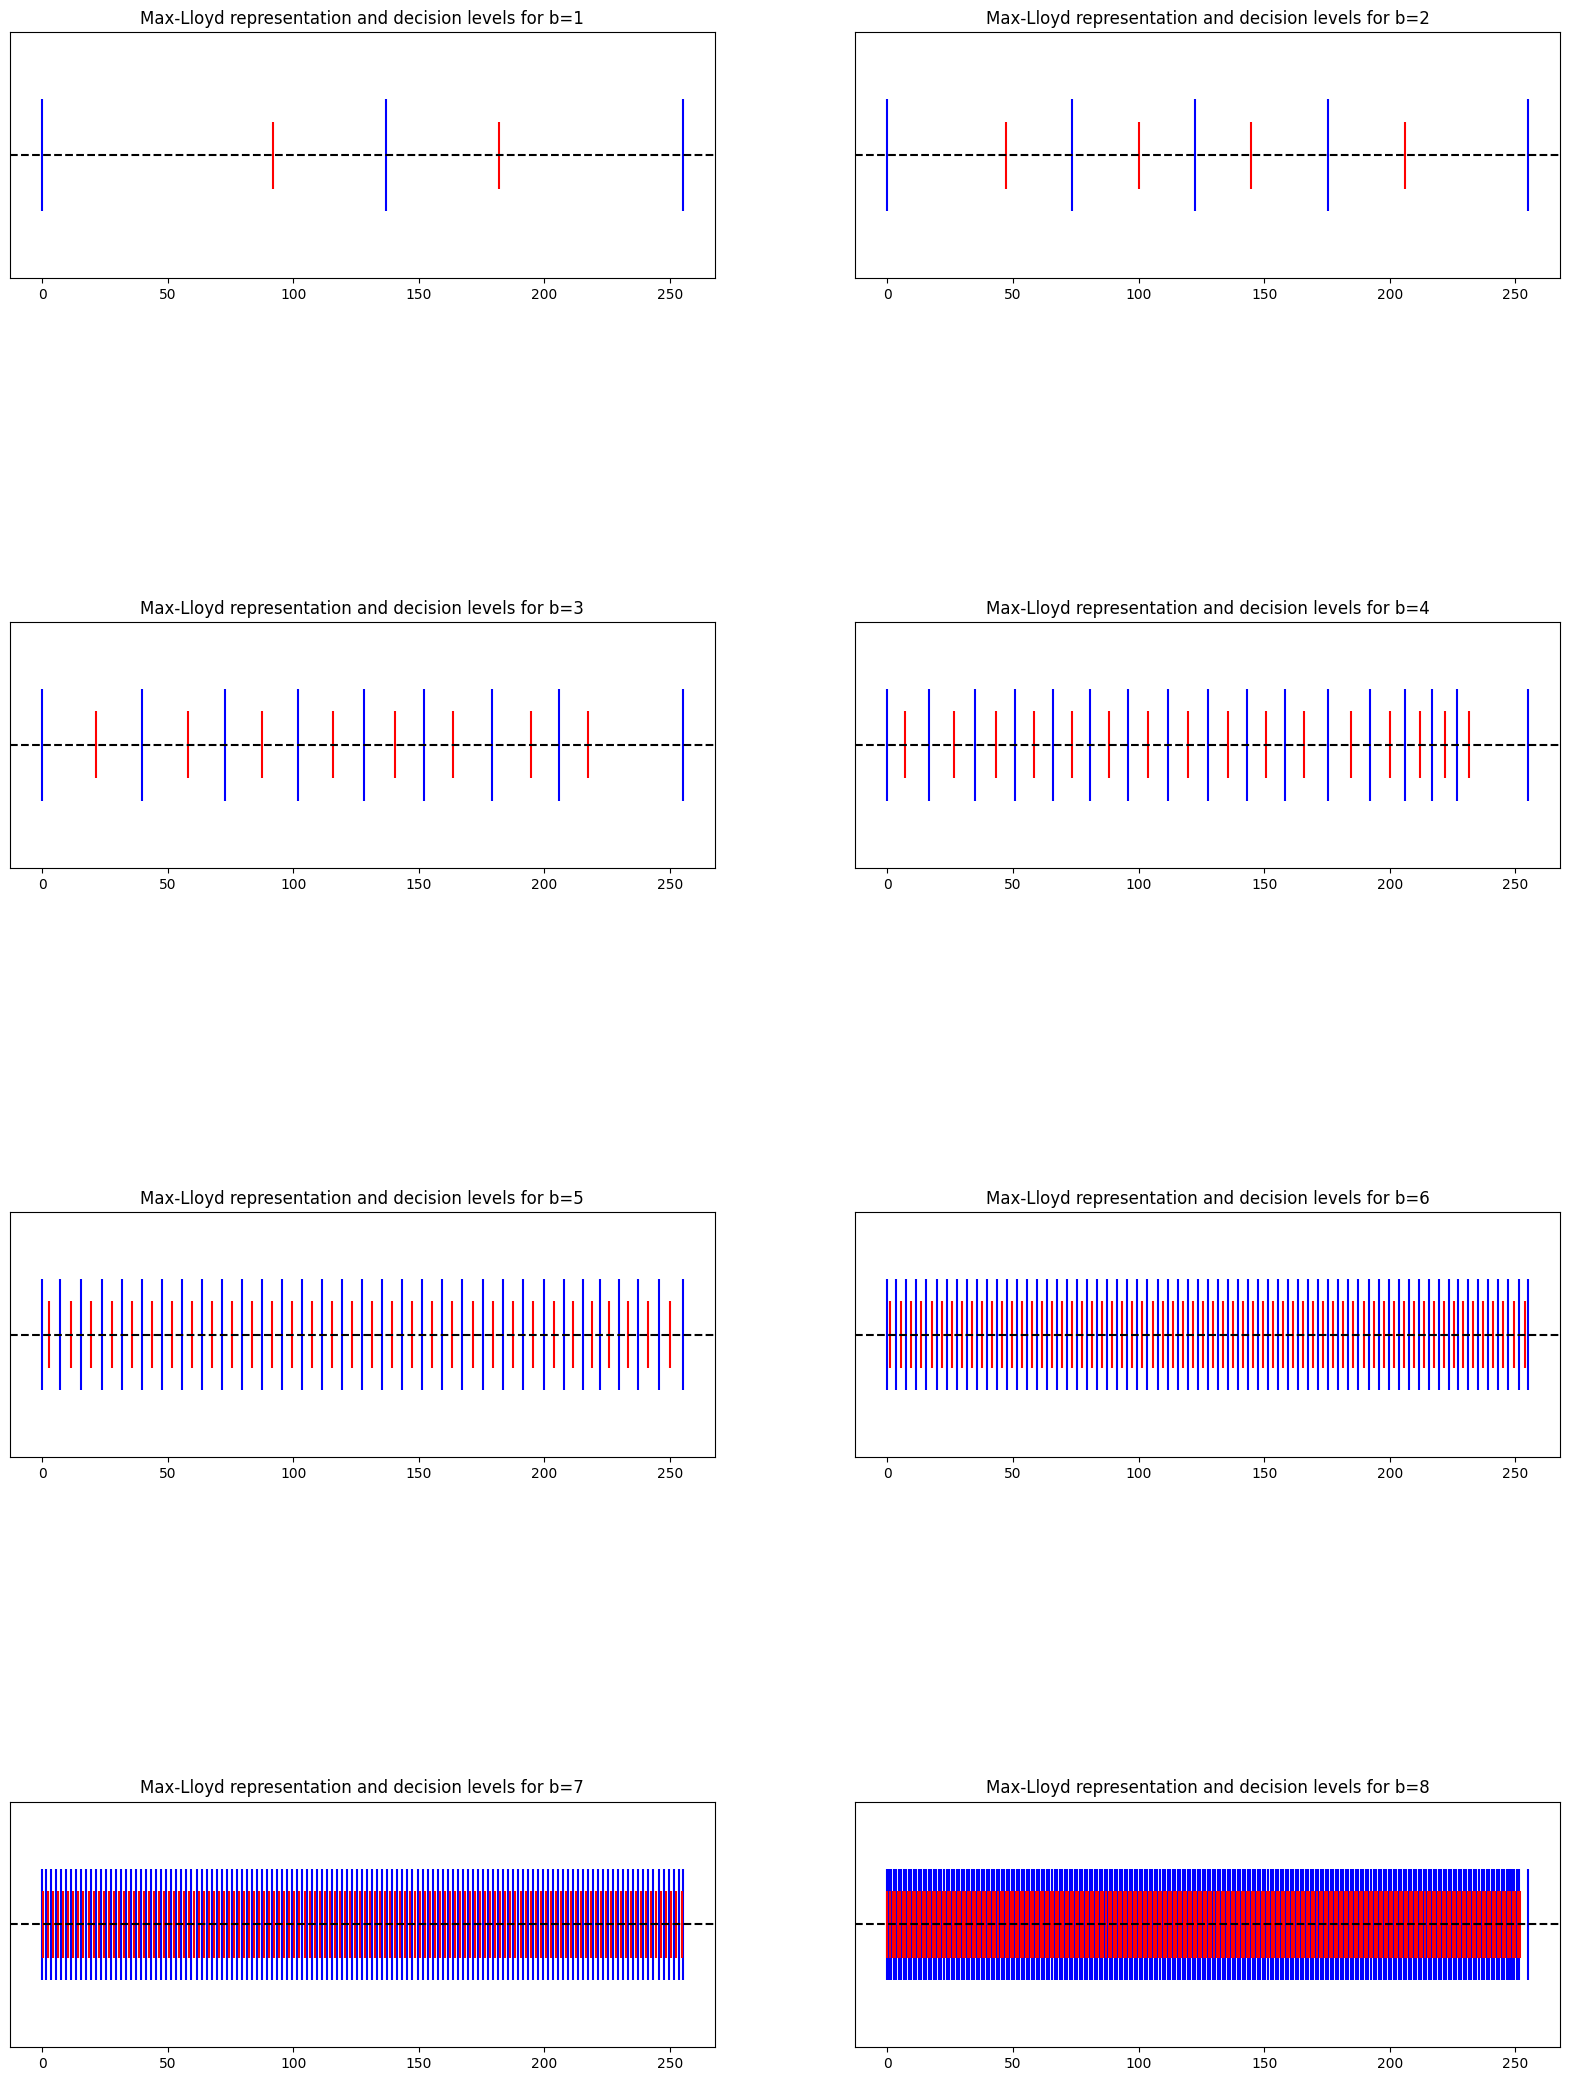

In [24]:
plt.figure( figsize=(20,30) )
for i in range(1, 9, 2):
    plt.subplot(8, 2, 2 * i - 1)
    plt.title(f"Max-Lloyd representation and decision levels for b={i}")
    plt.eventplot(decision_levels[i-1], 'horizontal', linelengths=0.5, colors='blue')
    plt.eventplot(repr_levels[i-1], 'horizontal', linelengths=0.3, colors='red')
    plt.axhline(y=1, color='black', linestyle='--')
    plt.yticks([])
    plt.subplot(8, 2, 2 * i)
    plt.title(f"Max-Lloyd representation and decision levels for b={i+1}")
    plt.eventplot(decision_levels[i], 'horizontal', linelengths=0.5, colors='blue')
    plt.eventplot(repr_levels[i], 'horizontal', linelengths=0.3, colors='red')
    plt.axhline(y=1, color='black', linestyle='--')
    plt.yticks([])

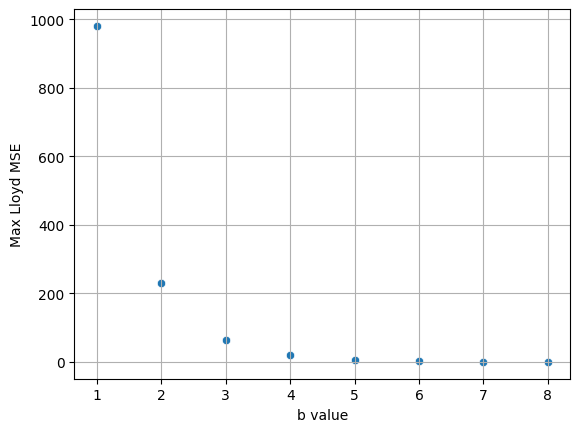

In [25]:
sns.scatterplot(y = max_lloyd_mse_list, x = b_list).set(xlabel="b value", ylabel="Max Lloyd MSE")
plt.grid()
plt.show()

# Q2 - Subsampling and Reconstruction

In [26]:
def calc_loss_images(img1: Image, img2: Image, criterion=''):
    arr1 = np.asarray(img1.getdata())
    arr2 = np.asarray(img2.getdata())
    arr = np.abs(arr1 - arr2)
    return sum(np.array([e**2 for e in arr]))

In [27]:
def subsample(img: Image, criterion, name):
    img_height = img.height
    img_width = img.width
    d_values = [2**n for n in range(1, 9)]
    mse_list = []
    for D in d_values:
        total_im = Image.new('L', img.size)
        edge_size = img.width // D
        i = 0
        loss = 0
        filename = f'imgs/q2_{name}_D_{D}.png'
        if os.path.isfile(filename):
            print(f'File {filename} exists')
            continue
        for h in range(int(D)):
            for w in range(int(D)):
                left = np.uint32(w * edge_size)
                top = np.uint32(h * edge_size)
                right = np.uint32(left + edge_size)
                bottom = np.uint32(top + edge_size)
                pos = (left, top, right, bottom)
                im = pil_image.crop(pos)
                value = criterion(im.getdata())
                im = Image.fromarray(value * np.ones(shape=(edge_size, edge_size)))
                total_im.paste(im, box=(left, top))
        if not os.path.isfile(filename):
            total_im.save(fp=filename)
            print(f'Saved image for {name} with {D=}')
        else:
            print(f'File {filename} exists')
    return


In [28]:
subsample(pil_image, np.median, 'cat_mad')
subsample(pil_image, np.mean, 'cat_mse')

File imgs/q2_cat_mad_D_2.png exists
File imgs/q2_cat_mad_D_4.png exists
File imgs/q2_cat_mad_D_8.png exists
File imgs/q2_cat_mad_D_16.png exists
File imgs/q2_cat_mad_D_32.png exists
File imgs/q2_cat_mad_D_64.png exists
File imgs/q2_cat_mad_D_128.png exists
File imgs/q2_cat_mad_D_256.png exists
File imgs/q2_cat_mse_D_2.png exists
File imgs/q2_cat_mse_D_4.png exists
File imgs/q2_cat_mse_D_8.png exists
File imgs/q2_cat_mse_D_16.png exists
File imgs/q2_cat_mse_D_32.png exists
File imgs/q2_cat_mse_D_64.png exists
File imgs/q2_cat_mse_D_128.png exists
File imgs/q2_cat_mse_D_256.png exists


In [29]:
mad_img_list = [Image.open(fp=f'imgs/q2_cat_mad_D_{D}.png') for D in [2**n for n in range(1, 9)]]
mse_img_list = [Image.open(fp=f'imgs/q2_cat_mse_D_{D}.png') for D in [2**n for n in range(1, 9)]]

In [30]:
def plot_image_lists(mad_img_list, mse_img_list):
    """ Plots the recieved matrices side by side. """
    plt.figure( figsize=(20,80) )
    d_values = [2**n for n in range(1, 9)]
    for k in range(1, 9):
        plt.subplot(8, 2, 2 * k - 1)
        plt.title(f"D={2**k} sub-sampling factor MAD:")
        plt.imshow(mad_img_list[k-1], cmap='gray')
        plt.subplot(8,2,2*k)
        plt.title(f"D={2**k} sub-sampling factor MSE:")
        plt.imshow(mse_img_list[k-1], cmap='gray')

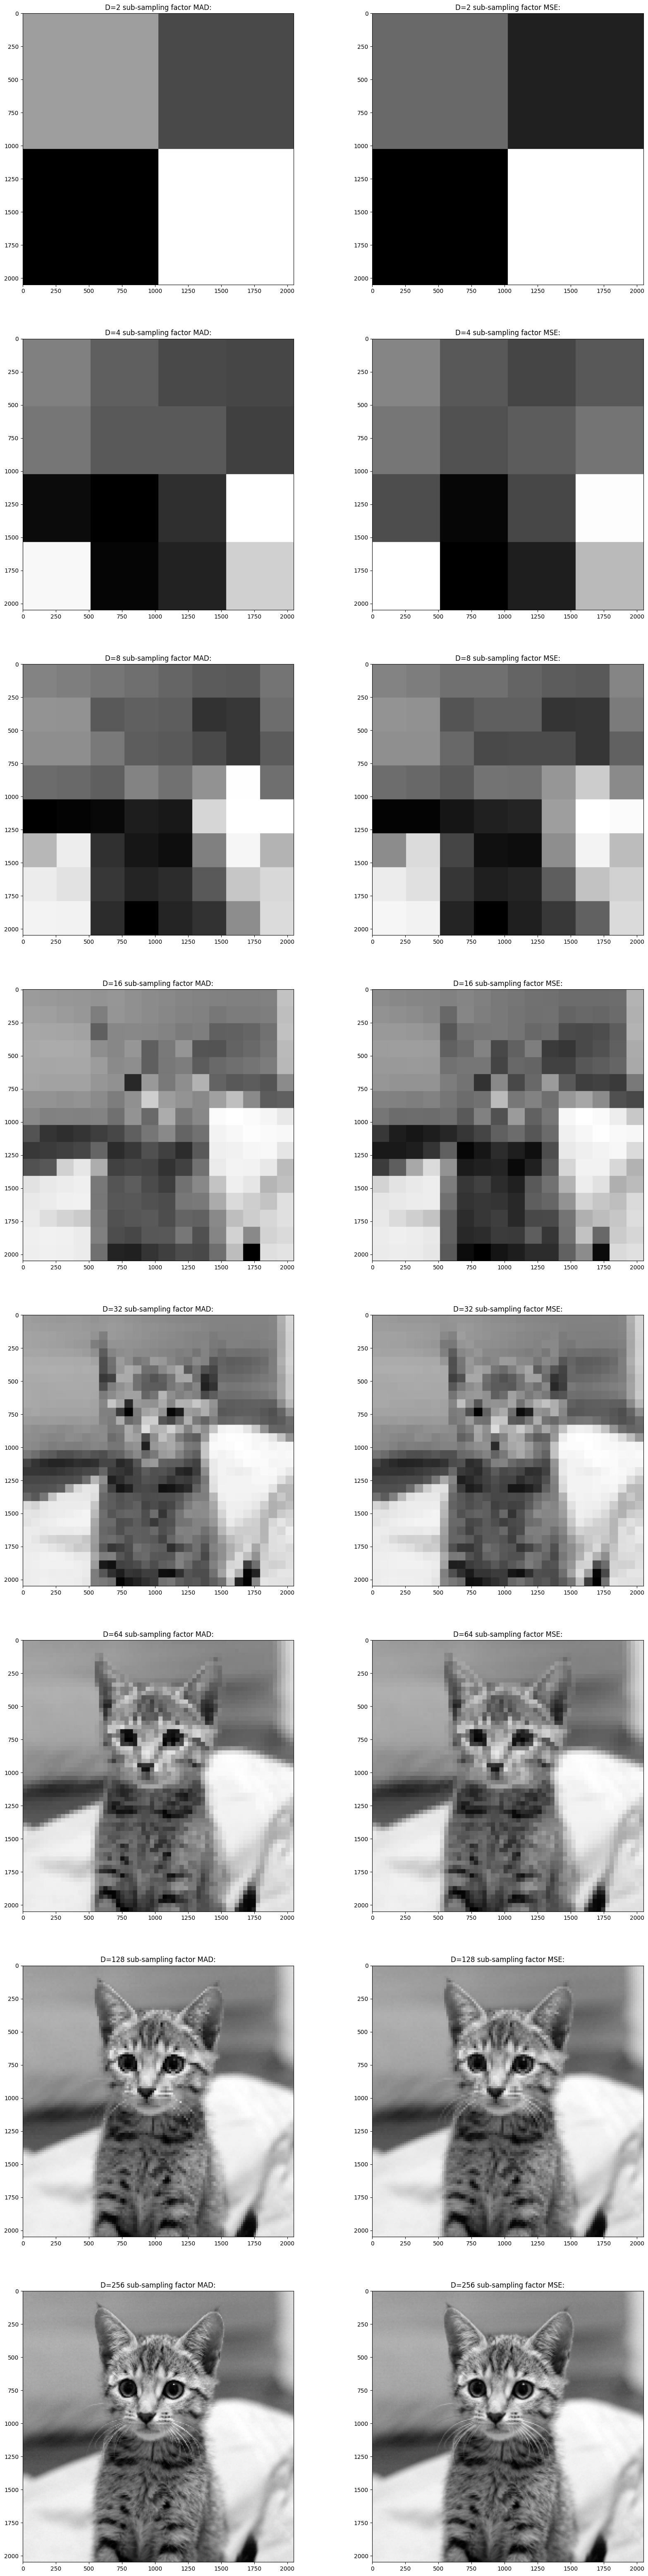

In [31]:
plot_image_lists(mad_img_list, mse_img_list)

## Q2.3 - discussion on subsampling factor $D$

As we can see in the images, using a higher $D$ yields a more feature-rich image, as there are more pixels in the photos.

As we try to find an optimal value for each $D\times D$ square, we can understand that the loss we get will be lower as $D$ increases.



In [38]:
mse_list = list(zip(list(range(1, 9)), max_lloyd_mse_list))

[Text(0.5, 0, 'D value'), Text(0, 0.5, 'MSE Error')]

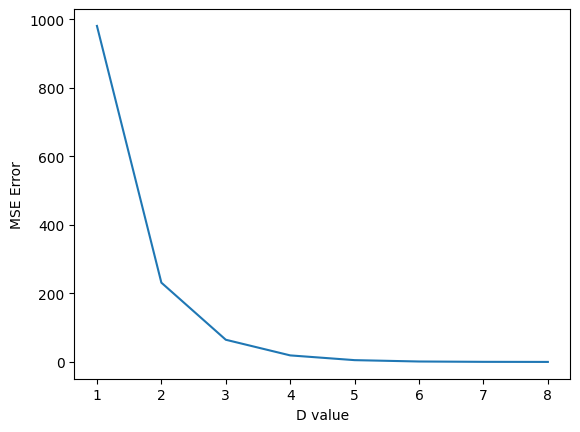

In [39]:
sns.lineplot(y = [e[1] for e in mse_list], x = [e[0] for e in mse_list]).set(xlabel="D value",
                                                                              ylabel="MSE Error")

[Text(0.5, 0, 'D value'), Text(0, 0.5, 'MAD Error')]

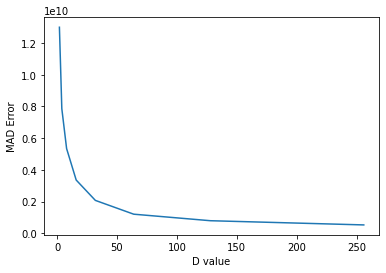

In [ ]:
sns.lineplot(y = [e[1] for e in mad_list], x = [e[0] for e in mad_list]).set(xlabel="D value",
                                                                              ylabel="MAD Error")

# Q3 - Solving the $L^p$ problem using the $L^2$ solution



In [40]:
def calc_weight_tag(x, y, eps, img, coeff, p, weight):
    img_arr = np.asarray(img)
    if float(img_arr[x][y]) - coeff < 1e-7 and p < 2:
        return np.power(eps, -1)
    w = np.power(np.abs(float(img_arr[x][y])- coeff), p-2.0) * weight[x][y]
    res = min([np.power(eps, -1), w])
    return min([np.power(eps, -1), w])

In [41]:
def create_uniform_boundaries(range_size, N):
    I = []
    interval_size = range_size / N
    for i in range(N):
        I.append(int(i * interval_size))
    return I

In [42]:
def calc_repr_delta(w, subsample: np.ndarray, eps, delta_i, p):
    new_subsample = np.zeros(subsample.shape)
    total_weight = 0
    for i in range(subsample.shape[0]):
        for j in range(subsample.shape[1]):
            sample_weight = calc_weight_tag(i, j, eps, subsample, delta_i, p, w)
            new_subsample[i, j] = sample_weight * subsample[i, j]
            total_weight += sample_weight
    return float(new_subsample.sum()) / total_weight

In [43]:
def calc_local_Lp(img, w, delta_i, p):
    return np.sum(np.power(np.abs(img - delta_i), p) * w)

In [44]:
def calc_Lp(img, w, repr_coeff, p, x_boundaries, y_boundaries):
    total_err = 0
    total_weight = w.sum()
    for i in range(len(repr_coeff) - 1):
        for j in range(len(repr_coeff) - 1):
            x_down = x_boundaries[i]
            x_up = x_boundaries[i+1]
            y_down = y_boundaries[j]
            y_up = y_boundaries[j+1]
            total_err += calc_local_Lp(img[x_down:x_up, y_down:y_up], 
                                        repr_coeff[i,j], p, 
                                        w[x_down:x_up, y_down:y_up])
    return total_err / total_weight


In [45]:
def solve_Lp(img, D, eps, p, stop_diff, weight_f):
    repr_coeff = np.ones((D, D)) * 128.0
    x_boundaries = create_uniform_boundaries(img.shape[0], D)
    y_boundaries = create_uniform_boundaries(img.shape[1], D)
    diff = stop_diff
    w = np.asarray([[weight_f(x, y) for x in range(img.shape[0])] for y in range(img.shape[1])])
    last_err = calc_Lp(img, w, repr_coeff, p, x_boundaries, y_boundaries)
    c=0
    while (diff >= stop_diff):
        print(f'Iter {c}')
        c += 1
        for i in range(D-1):
            for j in range(D-1):
                x_down = x_boundaries[i]
                x_up = x_boundaries[i+1]
                y_down = y_boundaries[j]
                y_up = y_boundaries[j+1]
                repr_coeff[i][j] = calc_repr_delta(w[x_down:x_up, y_down:y_up],
                                                    img[x_down:x_up, y_down:y_up],
                                                    eps, repr_coeff[i][j], p)                         
        curr_err = calc_Lp(img, w, repr_coeff, p, x_boundaries, y_boundaries)
        diff = np.abs(curr_err - last_err)
        last_err = curr_err
    return repr_coeff, last_err


## Q3.3 - L1 problem

In [46]:
def empiric_L1(repr_mat, img_shape):
    block_matrix = np.ones((img_shape[0] // repr_mat.shape[0], img_shape[1] // repr_mat.shape[1]))
    mad_mat = np.kron(repr_mat, block_matrix)
    return np.mean(np.abs(np.asarray(pil_image)) - mad_mat)

In [47]:
pil_arr = np.asarray(pil_image)
empiric_L1_repr = []
empiric_L1_errs = []
d_values = [2**n for n in range(1, 9)]
for D in d_values:
    L1_repr = np.ndarray((D, D), dtype=float)
    x_boundaries = create_uniform_boundaries(pil_arr.shape[0], D)
    y_boundaries = create_uniform_boundaries(pil_arr.shape[1], D)
    for i in range(len(x_boundaries) - 1):
        for j in range(len(y_boundaries) - 1):
            x_down = x_boundaries[i]
            x_up = x_boundaries[i+1]
            y_down = y_boundaries[j]
            y_up = y_boundaries[j+1]
            med = np.median(pil_arr[x_down:x_up, y_down:y_up])
            L1_repr[i][j] = med
    empiric_L1_repr.append(L1_repr)
    empiric_L1_errs.append(empiric_L1(L1_repr, pil_arr.shape))

## Question 3.4 - Comparing the empiric and approximation methods

In [48]:
def uniform_weight(i, j):
    return 1

In [49]:
L1_irls_reps = []
L1_irls_errs = []
L1_empiric_errs = []
d_values = [2**n for n in [2, 4, 6]]
for D in d_values:
    for eps in [float(10**e) for e in range(0, -6, -1)]:
        irls_rep, irls_err = solve_Lp(pil_arr, D, eps, p=1, stop_diff=0.5, weight_f=uniform_weight)
        L1_irls_reps.append(irls_rep)
        L1_irls_errs.append(irls_err)
        L1_empiric_errs.append(empiric_L1(irls_rep, pil_arr.shape))

Iter 0
Iter 1
Iter 2
Iter 3
Iter 4


KeyboardInterrupt: 

In [ ]:
def plot_Lp_images(img_list):
    plt.figure(figsize=(20,40))
    for i, b in enumerate( [2, 4, 6] ):
        plt.subplot(4, 2, b)
        plt.title(f"Using D={2**b} sub-sampling factor")
        plt.imshow(img_list[i], cmap='gray')

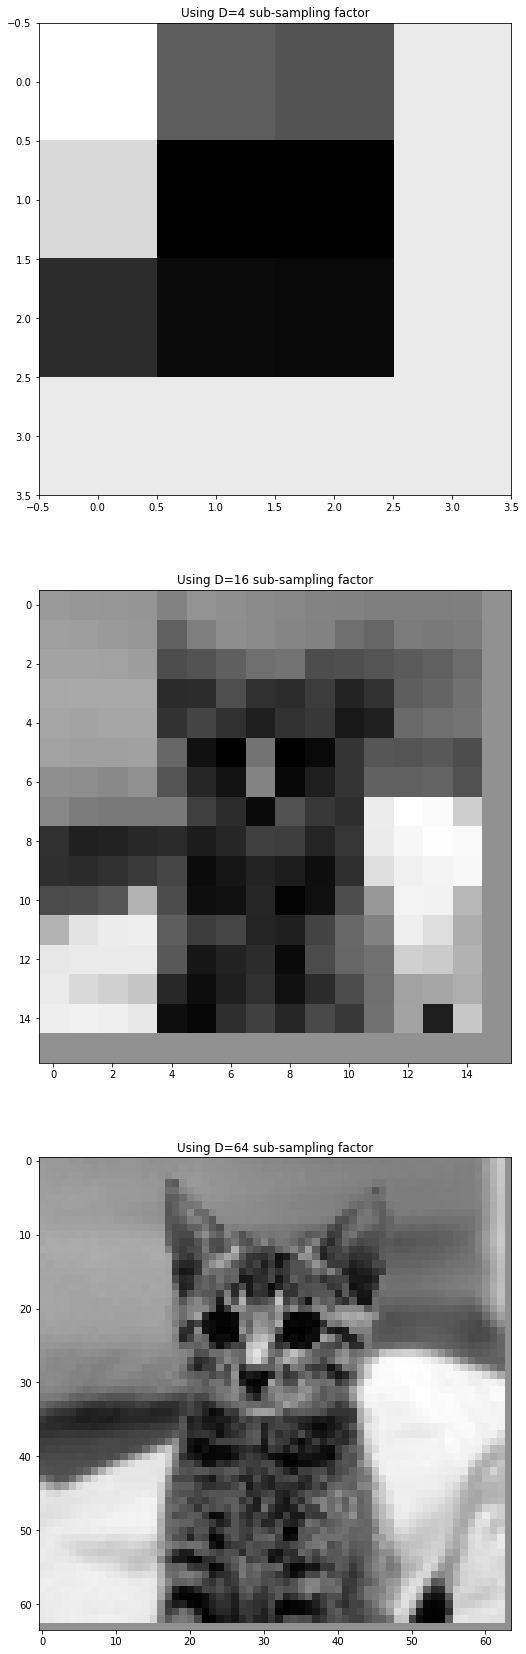

In [ ]:
plot_Lp_images(L1_irls_reps[::6])

In [ ]:
L1_list = zip(L1_irls_reps, L1_irls_errs, L1_empiric_errs)

In [ ]:
L4_reps = []
L4_errs = []
d_values = [2**n for n in range(1, 9)]
for D in d_values:
    L4_rep, L4_err = solve_Lp(pil_arr, D, eps=1.0, p=4, stop_diff=50, weight_f=uniform_weight)
    L4_errs.append(L4_err)
    L4_reps.append(L4_rep)

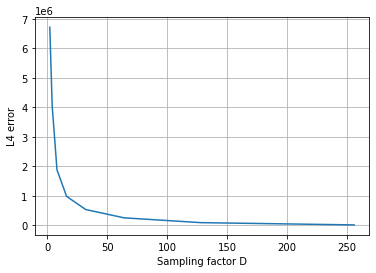

In [ ]:
sns.lineplot(y = L4_errs, x = [2**b for b in range(1,9)]).set(xlabel="Sampling factor D", ylabel="L4 error")
plt.grid()
plt.show()

In [ ]:
L1_5_reprs = []
L1_5_errs = []
d_values = [2**n for n in range(1, 9)]
for D in d_values:
    L1_5_repr, L1_5_err = solve_Lp(pil_arr, D, eps=1.0, p=1.5, stop_diff=0.5, weight_f=uniform_weight)
    L1_5_errs.append(L1_5_err)
    L1_5_reprs.append(L1_5_repr)

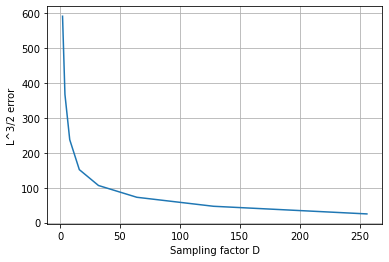

In [ ]:
sns.lineplot(y = L1_5_errs, x = [2**b for b in range(1,9)]).set(xlabel="Sampling factor D", ylabel="L^3/2 error")
plt.grid()
plt.show()